# Rofous Dev
This file is where you can test and develop functionalities for the rofous project

In [1]:
import numpy as np
from PID import PID
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Analytic_Solver import Analytic_Solver

In [38]:
G = -9.81


class DeviceID():
    def __init__(self, configs, pose_0, v_0, a_0, memory_length=50):
        self.configs = configs
        self.path = {'poses' : np.array([pose_0]),
                    'velocities' : np.array([v_0]),
                    'accelerations' : np.array([a_0])}
        self.memory_length = memory_length

    def add_odom(self, new_val, tag=''):
        assert len(tag) > 1, 'Odometry tag unclear: \n\t use [accelerations, velocities, poses]'
        if len(self.path[tag]) < self.memory_length:
            self.path[tag] = np.concatenate([self.path[tag],[new_val]])
        else:
            self.path[tag] = np.concatenate([self.path[tag][1:],[new_val]])


class Aerial_Device():
    """ This class is used to perform forward kinematics of an N-copter device
            - only quadcopter is stable
            - needs serious tuning 
            - can always double check the math
    """
    def __init__(self, mass=40, max_O=500, motor_config=np.array([(.2,.2,0), (-.2,.2,0), (-.2,-.2,0), (.2,-.2,0)]), motor_rotation_effect=np.array([[-1,1,1,-1],[1,1,-1,-1],[1,-1,1,-1]]), memory_length=100, p=.01, b=-.3):
        self.net_force = np.array([0,0,G*mass,0,0,0]) # Needs to be in the earth frame where [0,0,0,0,0,0] is start pose
        self.velocity = np.zeros(6)	# also in earth frame
        self.poseActual = np.zeros(6) # also in earth frame
        self.throttle = np.zeros(len(motor_config)) # rotations per second
        self.ans = Analytic_Solver()
        self.id = DeviceID({
            'mass' : mass,
            'max rpm' : max_O,
            'motor configuration' : motor_config,
            'rotational thrust' : motor_rotation_effect,
            'speed2thrust' : p,
            'vel2drag' : b},
            self.poseActual,
            self.velocity,
            self.net_force / mass,
            memory_length=memory_length)

    def reset(self):
        self.net_force = np.array([0,0,G*self.id.configs['mass'],0,0,0]) # Needs to be in the earth frame where [0,0,0,0,0,0] is start pose
        self.velocity = np.zeros(6)	# also in earth frame
        self.poseActual = np.zeros(6) # also in earth frame
        self.throttle = np.zeros(len(self.throttle)) # rotations per minute
        self.id.path['poses'] = np.array([self.poseActual])
        self.id.path['velocities'] = np.array([self.velocity])
        self.id.path['accelerations'] = np.array([self.net_force / self.id.configs['mass']])

    def set_throttles(self, speeds):
        for i,val in enumerate(speeds):
            self.throttle[i] = np.min([val, self.id.configs['max rpm']])

    def adjust_throttles(self, deltas):
        for i,val in enumerate(deltas):
            self.throttle[i] = np.min([np.max([val + self.throttle[i], 0]), self.id.configs['max rpm']])

    def update_odometry(self, t=0.05):
        """ forward kinematics pose update """
        self.update_net_force()
        self.update_velocity_and_pose(t)
        self.poseActual[3:] = self.ans.wrap_angles(self.poseActual[3:])
        self.velocity[3:] = self.ans.wrap_angles(self.velocity[3:])
        self.net_force[3:] = self.ans.wrap_angles(self.net_force[3:])

    def update_velocity_and_pose(self, t):
        """ velocity and pose are updated based on the 
        net forces acting on the device and the cycle_time 
        both are in the earth frame"""

        # simple F -> v -> s kinematics
        for i,component in enumerate(self.net_force):
            a = component / self.id.configs['mass']
            self.poseActual[i] += a * (t**2) / 2 + (self.velocity[i] * t) # x(i) = x(i-1) + v(i-1)t + (at^2)/2
            self.velocity[i] += a * t                                     # v(i) = v(i-1) + at

        self.id.add_odom(self.velocity, tag='velocities')
        self.id.add_odom(self.poseActual, tag='poses')

    def update_net_force(self):
        """ Calculates the thrust wrt the inertial 
        frame of the motors then rotates into 
        earth frame. This function operates
        with the assumption that Ft ~ omega^2 * p"""
        
        p = self.id.configs['speed2thrust']
        b = self.id.configs['vel2drag']
        thrusts = np.array([self.throttle[0]**2*p,self.throttle[1]**2*p,self.throttle[2]**2*p,self.throttle[3]**2*p])

        # calculate the inertial thrust as proportional to sum(omega^2)
        torque = np.matmul(self.id.configs['rotational thrust'], thrusts)
        i_thrust = np.array([0, 0, np.sum(thrusts), torque[0], torque[1], torque[2]])

        # calculate the drag force (w.r.t the earth frame) as inversly proprotional to velocity
        drag = self.velocity * b
        
        world_thrust = self.ans.R(i_thrust[:3], self.poseActual[3:])
        world_torque = self.ans.R(i_thrust[3:], self.poseActual[3:])
        # transform linear and angular thrusts, and store as new net_force
        self.net_force = np.concatenate([world_thrust, world_torque]).reshape(6) + drag

        # dont forget about gravity
        self.net_force[2] += G * self.id.configs['mass']

        # record data for later analysis
        self.id.add_odom(self.net_force / self.id.configs['mass'],tag='accelerations')


class Renderer():
    def __init__(self, device):
        self.device = device

    def render_device(self, ax, colors=['r', 'b'], verbose=0):
        """ plot the device and net-force indicator on a pre-made 3D axis object
            Does not call show() that must be done in main or in animate"""

        # plot motors as points based on motor configuration
        # plot lines from (0,0)_i -> motor_k_i
        for i,motor in enumerate(self.device.id.configs['motor configuration']):
            motor_pose = self.device.ans.T(self.device.ans.R(motor, self.device.poseActual[3:]), self.device.poseActual[:3])
            ax.scatter(motor_pose[0], motor_pose[1], motor_pose[2], color=colors[i % 2], marker='o', s=20)
            body_links = np.array(list(zip(self.device.poseActual[:3], motor_pose)))
            ax.plot(body_links[0], body_links[1], body_links[2], color='black', lw=3)

        # plot the pose history
        ax.plot(self.device.id.path['poses'][0][-10:], self.device.id.path['poses'][1][-10:], self.device.id.path['poses'][2][-10:], color='c')

        # plot a net force indicator
        indi = np.array(list(zip(self.device.poseActual, self.device.poseActual + self.device.net_force)))
        ax.plot(indi[0], indi[1], indi[2], color='y')

        ax.set_xlim((self.device.poseActual[0] - 10, self.device.poseActual[0] + 10))
        ax.set_ylim((self.device.poseActual[1] - 10, self.device.poseActual[1] + 10))
        ax.set_zlim((self.device.poseActual[2] - 10, self.device.poseActual[2] + 10))

        # print status
        if verbose > 0:
            print(f'New Pose:\n\tX : {self.device.poseActual[0]} \tY: {self.device.poseActual[1]} \tZ: {self.device.poseActual[2]} \tPhi: {self.device.poseActual[3]} \tTheta: {self.device.poseActual[4]} \tPsi: {self.device.poseActual[5]}')
            print(f'Net Forces:\n\tX : {self.device.net_force[0]} \tY: {self.device.net_force[1]} \tZ: {self.device.net_force[2]} \tPhi: {self.device.net_force[3]} \tTheta: {self.device.net_force[4]} \tPsi: {self.device.net_force[5]}')


    def populate_ax_from_id(self,ax,odom,colors,label='',title=''):
        """ Given an array shape (n,6) will plot against time"""
        t_span = np.array(range(len(odom)))
        ax.clear()
        ax.plot(t_span, odom[:,0], color=colors[0], label=f'X-{label}')
        ax.plot(t_span, odom[:,1], color=colors[1], label=f'Y-{label}')
        ax.plot(t_span, odom[:,2], color=colors[2], label=f'Z-{label}')
        ax.plot(t_span, odom[:,3], color=colors[3], label=f'Phi-{label}')
        ax.plot(t_span, odom[:,4], color=colors[4], label=f'Theta-{label}')
        ax.plot(t_span, odom[:,5], color=colors[5], label=f'Psi-{label}')
        ax.set_title(title)
        ax.legend()

    def render_velocity(self,ax,colors):
        self.populate_ax_from_id(ax, self.device.id.path['velocities'], colors, label='Velocity', title='Velocity over time')

    def render_acceleration(self, ax, colors):
        self.populate_ax_from_id(ax, self.device.id.path['accelerations'], colors, label='Acceleration', title='Acceleration over time')

    def render_pose(self, ax, colors):
        self.populate_ax_from_id(ax, self.device.id.path['poses'], colors, label='Poses', title='Poses over time')

    def render(self, colors=['r','b','g','c','m','y'], v=0):
        """ Current render method pretty weak
        It would be nice to not use matplotlib"""
        fig = plt.figure(figsize=(15,8))
        axes = [fig.add_subplot(221, projection='3d'),
                fig.add_subplot(222),
                fig.add_subplot(223),
                fig.add_subplot(224)]

        self.render_device(axes[0], colors=colors[:2], verbose=v)
        self.render_pose(axes[1], colors)
        self.render_velocity(axes[2], colors)
        self.render_acceleration(axes[3], colors)

        plt.show()

### PID example

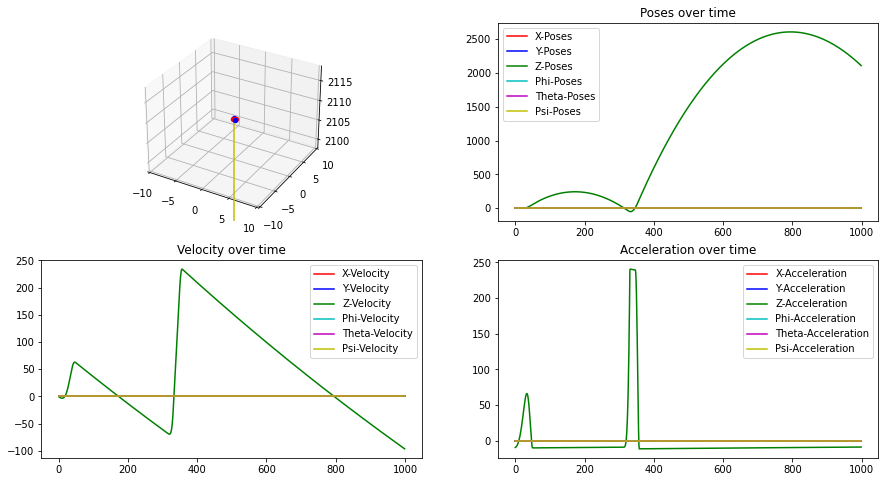

In [66]:
rofous = Aerial_Device(memory_length=1000)
ac = PID(kp=0.8, ki=0.0, kd=-0.02) # strictly altitude control
artist = Renderer(rofous)
target = (0,0,10,0,0,0)
rofous.reset()

for i in range(1000):
    delta = ac.converge(rofous.poseActual[2], target[2])
    rofous.adjust_throttles([delta, delta, delta, delta])
    rofous.update_odometry()
    if np.abs(np.sum(rofous.id.path['poses'][-5:,2])) < 1e-6:
        break
        
artist.render()

In [79]:
def step(rofous, target):
    rofous.reset()
    p_ctr = 0
    peak = 0
    max_o = 0
    for j in range(10000):
        rofous.adjust_throttles(target=target)
        rofous.update_odometry()

        # if velocity changes sign the pose is beginning an oscillation
        if np.sign(np.sum(rofous.id.path['velocities'][-1])) != np.sign(np.sum(rofous.id.path['velocities'][-2])):
            if np.linalg.norm(rofous.poseActual - target) > max_o and j != 0:
                max_o = np.linalg.norm(rofous.poseActual - target)
                peak = j
            p_ctr += 1
        if np.abs(np.sum(rofous.id.path['poses'][-5:])) < 1e-3:
            break
    return p_ctr * 100 / (max_o + peak + 1e-5)

0.04997346969700083 1e-05
0.049973472811089784 1e-05
0.04997347592467401 1e-05
0.04997347903775345 1e-05
0.049973482150328034 1e-05
0.04997348526239775 1e-05
0.04997348837396246 1e-05
0.049973491485022184 1e-05
0.04997349459557679 1e-05
0.049973497705626355 1e-05
[0.500005 0.       0.      ]


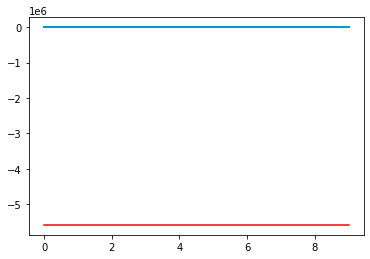

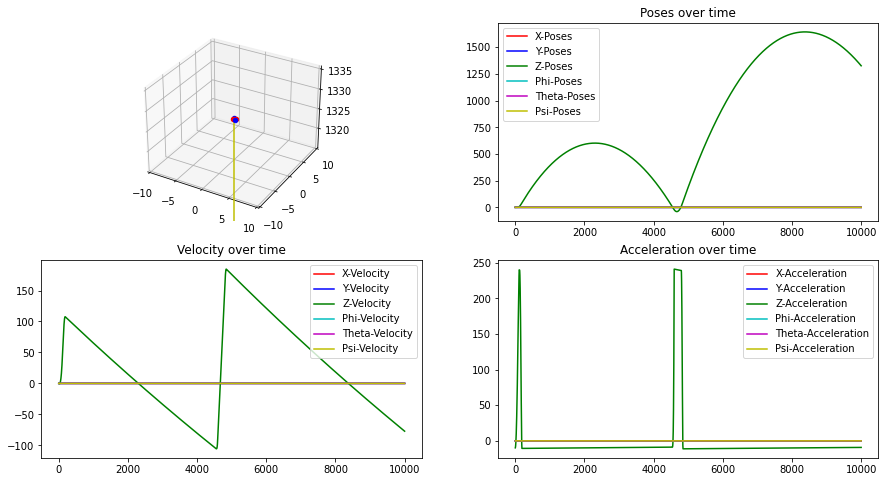

In [86]:
rofous = Aerial_Device.Aerial_Device(memory_length=10000)
artist = Aerial_Device.Renderer(rofous)
target = [0,0,10,0,0,0]

sp = [np.linalg.norm(target)]
pv = []
op = []
a = 1e-5
scores = []
rofous.control.gains = np.array([0.5, 0, 0])
gains = []

for i in range(10):
    score = step(rofous, target)
    scores.append(score)
    gains.append(rofous.control.gains)
    d_gain = [score*a, max_o*peak*a, peak*a/5]
    print(score, d_gain)
    rofous.control.gains += np.array(d_gain)
        
print(rofous.control.gains)  
gains = np.array(gains)
x = np.arange(0,len(scores))
"""
plt.plot(x, ((pv-np.mean(pv)) / np.std(pv)) + sp[0], 'r', label='Effect')
plt.plot(x, ((op-np.mean(op)) / np.std(op)) + sp[0], 'g', label='Control')
plt.plot(x, sp*len(pv), 'b', label='Target')
plt.legend()
plt.show()"""

plt.plot(x, gains[:,0], 'g')
plt.plot(x, gains[:,1], 'b')
plt.plot(x, gains[:,2], 'c')
plt.plot(x, scores-np.mean(scores)/np.std(scores), 'r')
plt.show()
   
artist.render()